### Introduction

Facebook is one of the biggest online advertisers’ platforms and a lot of data are generated on Facebook daily, 
that also helps advertisers track the success of their campaigns and add valuable information such as demographic 
information. 

Here, we are going to look at dataset named Facebook_Ads_2.csv. 

Project has basic reasurch purpose to understand what model in combination with different techniques is optimal in current dataset 

### Import Libraries

In [ ]:
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
import requests, json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MaxAbsScaler, RobustScaler, FunctionTransformer, PowerTransformer, OrdinalEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score , roc_auc_score, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

### Additional
>#### Explanation

basic - basic model with StandardScaler, LogisticRegression(random_state = 0) and added variable 'gender'

>#### Variable

In [ ]:
cols = ['Time Spent on Site','Salary']

In [ ]:
#Dataframes to store results of various metrics
results__accuracy = pd.DataFrame(columns=['modelName', 'accuracy_test', 'accuracy_train'])
results_rocauc = pd.DataFrame(columns=['modelName', 'rocauc_test', 'rocauc_train'])
results_precision = pd.DataFrame(columns=['modelName', 'precision_test', 'precision_train'])
results_recall = pd.DataFrame(columns=['modelName', 'recall_test', 'recall_train'])
results_f1 = pd.DataFrame(columns=['modelName', 'f1_test', 'f1_train'])

>#### Functions

In [ ]:
#shows if there are any empty values in %
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                 'percent_missing': percent_missing})
    print(missing_value_df)

In [ ]:
#shows current distribution vs normal distribution
def compare_to_normal (df, var, name):
    data = df[var]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(name)
    plt.show()
    return plt

In [ ]:
#transform variable and show results on graph
def transform_print(X_train,col, var , tranformer, name):
    tranformer.fit(X_train[col])
    X_train_t = tranformer.transform(X_train[cols])
    X_train_t = pd.DataFrame(X_train_t, columns = cols)
    pl = compare_to_normal(X_train_t, var, name) 
    diagnostic_plots(X_train_t, var, pl)   

In [ ]:
#complex transformation. transforms variable via several transformers and shows all results on graph.
def transform(X_train,col, var):
    rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
    sqr_transformer = FunctionTransformer(lambda x: x ** (1 / 2), validate = True)
    exp_transformer = FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True)
    yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)
    bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)
    transformer_list=[rcpr_transformer,sqr_transformer, exp_transformer, yj_transformer, bc_transformer ]
    transformer_names = ["rcpr_transformer","sqr_transformer", "exp_transformer", "yj_transformer", "bc_transformer" ]
    for j in range(0, len(transformer_list)):
         transform_print(X_train,col, var , transformer_list[j], transformer_names[j]) 

In [ ]:
#shows results of transformation on graph
def diagnostic_plots(df, variable, pl):
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    plt.xlabel(variable)
    df[variable].hist(bins = 30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist = 'norm', plot = plt)
    plt.xlabel(variable)
    plt.show()

In [ ]:
#complex function to train, show results and save them
def train_report_hist (name, scaler, classifier, isTransformer, transformer):
  #if transformer was requested
    if isTransformer==True:
      #transform
        tr = transformer
        X_train_t = tr.fit_transform(X_train)
        X_test_t = tr.transform(X_test)
        #scale
        sc = scaler
        X_train_sc = sc.fit_transform(X_train_t)
        X_test_sc = sc.transform(X_test_t) 
    else:
      #if no transformer requested
      #scaler
        sc = scaler
        X_train_sc = sc.fit_transform(X_train)
        X_test_sc = sc.transform(X_test) 
    #fit the model    
    clf = classifier
    clf.fit(X_train_sc, y_train) 
    
    #show train results
    print(name)
    print('Train: ')
    y_pred_train = clf.predict(X_train_sc)
  
    print('accuracy %s' % accuracy_score(y_train, y_pred_train))
    cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()
    print(classification_report(y_train, y_pred_train))

    print('----------------------------------------------\n')
    #show test results
    print('Test: ')
    y_pred_test = clf.predict(X_test_sc)
  
    print('accuracy %s' % accuracy_score(y_test, y_pred_test))
    cm_t = confusion_matrix(y_test, y_pred_test,labels=clf.classes_)
    disp_t = ConfusionMatrixDisplay(confusion_matrix=cm_t,display_labels=clf.classes_)
    disp_t.plot()
    plt.show()
    
    print(classification_report(y_test, y_pred_test))
    #save results
    results__accuracy.loc[len(results__accuracy.index)] = [name, accuracy_score(y_test,y_pred_test), accuracy_score(y_train, y_pred_train)]
    results_rocauc.loc[len(results_rocauc.index)] = [name, roc_auc_score(y_test, y_pred_test), roc_auc_score(y_train, y_pred_train)]
    results_precision.loc[len(results_precision.index)] = [name, precision_score(y_test,y_pred_test), precision_score(y_train, y_pred_train)]
    results_recall.loc[len(results_recall.index)] = [name, recall_score(y_test,y_pred_test), recall_score(y_train, y_pred_train)]
    results_f1.loc[len(results_f1.index)] = [name, f1_score(y_test,y_pred_test), f1_score(y_train, y_pred_train)]


In [ ]:
#split dataset on train and test with specified columns
def reset_t_t_split(cols):
    X_train, X_test, y_train, y_test = train_test_split(
    dataset[cols],
    dataset['Clicked'],
    test_size = 0.2,
    random_state = 0)
    return X_train, X_test, y_train, y_test

In [ ]:
#shows normal distribution and box plot graphs before transformation vs after transformation
def norm_bp_compare(y_before, y_after):
    plt.figure(figsize=(16,8))
    ax1=plt.subplot(2,2,1)
    a = sns.distplot(dataset[y_before])
    plt.subplot(2,2,2)
    sns.boxplot(x='Clicked', y=y_before, data = dataset)
    ax2=plt.subplot(2,2,3)
    b = sns.distplot(dataset[y_after])
    plt.subplot(2,2,4)
    sns.boxplot(x='Clicked', y=y_after, data = dataset)
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()

In [ ]:
#shows boxplot of two datasest where in one all records with clicked and later with not clicked
def boxplot_compare(y_before, y_after):
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    a = sns.boxplot(x='Clicked', y=y_before, data = dataset)

    plt.subplot(1, 2, 2)
    b = sns.boxplot(x='Clicked', y=y_after, data = dataset)
    
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()  

In [ ]:
#use method of trimming (5th and 90th percentile to treat outliers)
def trimming (var, colName):
    fifth_percentile = np.percentile(dataset[var], 5) 
    ninetieth_percentile = np.percentile(dataset[var], 90) 
    print(fifth_percentile, ninetieth_percentile) 
    b = np.where(dataset[var]<fifth_percentile, fifth_percentile, dataset[var]) 
    b = np.where(b>ninetieth_percentile, ninetieth_percentile, b) 
    dataset[colName] = b.tolist()
    norm_bp_compare(var, colName)

In [ ]:
#find if we have outliers
def detect_outliers_iqr(data, var):
    outliers = []
    df = data[var].to_numpy()
    data = sorted(df)
    q1 = np.percentile(df, 25)
    q3 = np.percentile(df, 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

In [ ]:
# define function to show briefly the results
def show_results():
    print('Accuracy')
    new_results__accuracy = results__accuracy.sort_values('accuracy_test', ascending = False)
    print(new_results__accuracy)
    print('----------------------------------------------\n')
    print('RocAuc')
    new_results_rocauc = results_rocauc.sort_values('rocauc_test', ascending = False)
    print(new_results_rocauc)
    print('----------------------------------------------\n')
    print('Precision')
    new_results_precision = results_precision.sort_values('precision_test', ascending = False)
    print( new_results_precision)
    print('----------------------------------------------\n')
    print('Recall')
    new_results_recall = results_recall.sort_values('recall_test', ascending = False)
    print(new_results_recall)
    print('----------------------------------------------\n')
    print('f1')
    new_results_f1 = results_f1.sort_values('f1_test', ascending = False)
    print(new_results_f1)

In [ ]:
#use discritization
def discr():
    disc = EqualFrequencyDiscretiser(q=10, variables=['Time Spent on Site_Discr', 'Salary_Discr'])
    disc.fit(X_train_d)
    X_train= disc.transform(X_train_d)
    X_test= disc.transform(X_test_d)
    return X_train, X_test

### Dataset Introduction
#### Info

In [ ]:
dataset = pd.read_csv('../Facebook_Ads_2.csv', encoding = "ISO-8859-1")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Names               499 non-null    object 
 1   emails              499 non-null    object 
 2   Country             499 non-null    object 
 3   Time Spent on Site  499 non-null    float64
 4   Salary              499 non-null    float64
 5   Clicked             499 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 23.5+ KB


In [ ]:
dataset.describe()

,Time Spent on Site,Salary,Clicked
count,499.000000,499.000000,499.000000
mean,32.920178,52896.992469,0.501002
std,9.103455,18989.183150,0.500501
min,5.000000,20.000000,0.000000
25%,26.425044,38888.117260,0.000000
50%,33.196067,52840.913110,1.000000
75%,39.114995,65837.288190,1.000000
max,60.000000,100000.000000,1.000000


In [ ]:
dataset.head()

,Names,emails,Country,Time Spent on Site,Salary,Clicked
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,25.649648,55330.06006,0
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,32.456107,79049.07674,1
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,20.945978,41098.60826,0
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,54.039325,37143.35536,1
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,34.249729,37355.11276,0


In [ ]:
click = dataset[dataset['Clicked']==1] 

In [ ]:
no_click =  dataset[dataset['Clicked']==0]

In [ ]:
print ('Total = ', len(dataset))
print('Number of customer who clicked on ad = ', len(click))
print('Percentage clicked =', 1.*len(click)/ len(dataset)*100., '%')
print('Did not click = ', len(no_click))
print('Percentage who did not click = ', 1.*len(no_click)/ len(dataset)*100., "%")

Total =  499
Number of customer who clicked on ad =  250
Percentage clicked = 50.1002004008016 %
Did not click =  249
Percentage who did not click =  49.899799599198396 %


#### Extract additional Info
>#### Gender via name

In [ ]:
#Create new col 'Gender' and clean in col 'Name' unnecessary info
dataset["Gender"] = np.nan
dataset['Names'] = dataset['Names'].str.partition(' ')[0]
dataset['Names'] = dataset['Names'].str.partition(',')[0]

In [ ]:
# function to convert each name to gender
def getGender(df):
    gender_list = []
    for name in df['Names']:
        content = requests.get(f'https://api.genderize.io/?name={name}').text
        gender = json.loads(content)['gender']
        gender_list.append(gender)
    df.loc[:, "Gender"] = gender_list

In [ ]:
getGender(dataset)

In [ ]:
dataset.Gender.value_counts()

male      341
female    156
Name: Gender, dtype: int64

In [ ]:
def nans(dataset): return dataset[dataset.isnull().any(axis=1)]

In [ ]:
nans(dataset)

,Names,emails,Country,Time Spent on Site,Salary,Clicked,Gender
455,Tamekah,ut.pharetra@ametultricies.net,Costa Rica,37.085105,91568.97221,1,None
474,Avye,Cras@eros.net,Armenia,44.893467,71840.40455,1,None


In [ ]:
dataset['Gender'] = dataset['Gender'].replace({None:'male'})

In [ ]:
nans(dataset)

,Names,emails,Country,Time Spent on Site,Salary,Clicked,Gender


>#### Countries modification

In [ ]:
# group islands according to countries they belong to
def replace_country (dataset):
    creplace_list = []
    for j in range(0, len(dataset)):
        if dataset.iloc[j]['Country'] == 'viet nam':
            creplace_list.insert(j, 'vietnam')
        elif dataset.iloc[j]['Country'] == 'korea, south':
            creplace_list.insert(j, 'south korea')
        elif dataset.iloc[j]['Country'] == 'united kingdom (great britain)' or dataset.iloc[j]['Country'] =='saint helena, ascension and tristan da cunha' or dataset.iloc[j]['Country'] == 'turks and caicos islands' or dataset.iloc[j]['Country'] =='anguilla' or dataset.iloc[j]['Country'] =='jersey' or dataset.iloc[j]['Country'] =='virgin islands, british' or dataset.iloc[j]['Country'] =='guernsey' or dataset.iloc[j]['Country'] =='bermuda' or dataset.iloc[j]['Country'] =='isle of man' or dataset.iloc[j]['Country'] =='south georgia and the south sandwich islands'  or dataset.iloc[j]['Country'] =='cayman islands':
            creplace_list.insert(j, 'united kingdom')
        elif dataset.iloc[j]['Country'] == 'palestine, state of':
            creplace_list.insert(j, 'palestine')
        elif dataset.iloc[j]['Country'] == 'macedonia':
            creplace_list.insert(j, 'north macedonia')
        elif dataset.iloc[j]['Country'] == 'san marino':
            creplace_list.insert(j, 'italy')
        elif dataset.iloc[j]['Country'] == 'guadeloupe' or dataset.iloc[j]['Country'] =='new caledonia'or dataset.iloc[j]['Country'] == 'french southern territories' or dataset.iloc[j]['Country'] == 'saint pierre and miquelon' or dataset.iloc[j]['Country'] == 'french guiana' or dataset.iloc[j]['Country'] =='reunion' or dataset.iloc[j]['Country'] =='mayotte' or dataset.iloc[j]['Country'] == 'martinique' or dataset.iloc[j]['Country'] =='wallis and futuna' or dataset.iloc[j]['Country'] =='french polynesia' or dataset.iloc[j]['Country'] =='saint barthélemy':
            creplace_list.insert(j, 'france')
        elif dataset.iloc[j]['Country'] == 'sint maarten' or dataset.iloc[j]['Country'] =='curaçao':
            creplace_list.insert(j, 'netherlands')
        elif dataset.iloc[j]['Country'] == 'tokelau' or dataset.iloc[j]['Country'] == 'cook islands' or dataset.iloc[j]['Country'] =='niue':
            creplace_list.insert(j, 'new zealand')
        elif dataset.iloc[j]['Country'] == 'åland islands':
            creplace_list.insert(j, 'finland')
        elif dataset.iloc[j]['Country']=='united states minor outlying islands' or dataset.iloc[j]['Country'] =='puerto rico' or dataset.iloc[j]['Country'] == 'guam' or dataset.iloc[j]['Country'] =='northern mariana islands' or dataset.iloc[j]['Country'] =='virgin islands, united states' or dataset.iloc[j]['Country'] =='american samoa':
            creplace_list.insert(j, 'united states')
        elif dataset.iloc[j]['Country'] == 'macao':
            creplace_list.insert(j, 'china') 
        elif dataset.iloc[j]['Country'] == 'christmas island' or dataset.iloc[j]['Country'] == 'heard island and mcdonald islands' or dataset.iloc[j]['Country'] =='cocos (keeling) islands' or dataset.iloc[j]['Country'] =='norfolk island':
            creplace_list.insert(j, 'australia')
        elif dataset.iloc[j]['Country'] == 'aruba' or dataset.iloc[j]['Country'] =='bonaire, sint eustatius and saba':
            creplace_list.insert(j, 'netherlands')
        elif dataset.iloc[j]['Country'] == 'bouvet island':
            creplace_list.insert(j, 'norway')
        elif dataset.iloc[j]['Country'] == 'faroe islands':
            creplace_list.insert(j, 'denmark')
        else:
            creplace_list.insert(j, dataset.iloc[j]['Country'])
    dataset.loc[:, 'Country'] = creplace_list
    return dataset

In [ ]:
#crearte additional column for modified countries and change to lowercase
dataset["Country_Orig"] = dataset["Country"]
dataset["Country"] = [x.lower() for x in dataset["Country"]]
dataset["Country_Orig"] = [x.lower() for x in dataset["Country_Orig"]]

In [ ]:
dataset = replace_country(dataset)

In [ ]:
dataset

,Names,emails,Country,Time Spent on Site,Salary,Clicked,Gender,Country_Orig
0,Martina,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,bulgaria,25.649648,55330.06006,0,female,bulgaria
1,Harlan,eu.dolor@diam.co.uk,belize,32.456107,79049.07674,1,male,belize
2,Naomi,vulputate.mauris.sagittis@ametconsectetueradip...,algeria,20.945978,41098.60826,0,female,algeria
3,Jade,malesuada@dignissim.com,new zealand,54.039325,37143.35536,1,female,cook islands
4,Cedric,felis.ullamcorper.viverra@egetmollislectus.net,brazil,34.249729,37355.11276,0,male,brazil
...,...,...,...,...,...,...,...,...
494,Rigel,egestas.blandit.Nam@semvitaealiquam.com,sao tome and principe,19.222746,44969.13495,0,male,sao tome and principe
495,Walter,ligula@Cumsociis.ca,nepal,22.665662,41686.20425,0,male,nepal
496,Vanna,Cum.sociis.natoque@Sedmolestie.edu,zimbabwe,35.320239,23989.80864,0,female,zimbabwe
497,Pearl,penatibus.et@massanonante.com,philippines,26.539170,31708.57054,0,female,philippines


### Visualize Dataset

In [ ]:
print('male percentage =', (len(dataset[dataset['Gender'] == 'male']) / len(dataset)) * 100, '%')
print('female percentage =', (len(dataset[dataset['Gender'] == 'female']) / len(dataset)) * 100, '%')

male percentage = 68.7374749498998 %
female percentage = 31.262525050100198 %


In [ ]:
print('male percentage clicked=', (len(dataset_male[dataset_male['Clicked'] == 1]) / len(dataset_male)) * 100, '%')
print('male percentage did not clicked=', (len(dataset_male[dataset_male['Clicked'] == 0]) / len(dataset_male)) * 100, '%')

male percentage clicked= 54.518950437317784 %
male percentage did not clicked= 45.481049562682216 %


In [ ]:
print('female percentage clicked=', (len(dataset_female[dataset_female['Clicked'] == 1]) / len(dataset_female)) * 100, '%')
print('female percentage did not clicked=', (len(dataset_female[dataset_female['Clicked'] == 0]) / len(dataset_female)) * 100, '%')

female percentage clicked= 40.38461538461539 %
female percentage did not clicked= 59.61538461538461 %


<IPython.core.display.Javascript object>


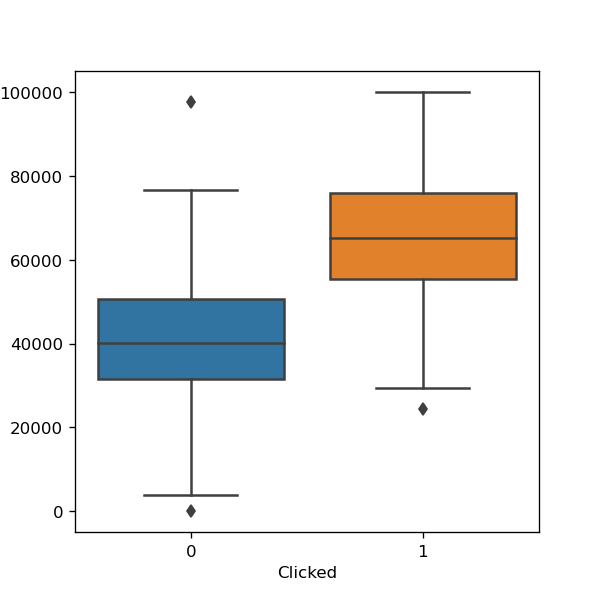

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='Clicked', y='Salary', data = dataset)
plt.show()

<IPython.core.display.Javascript object>


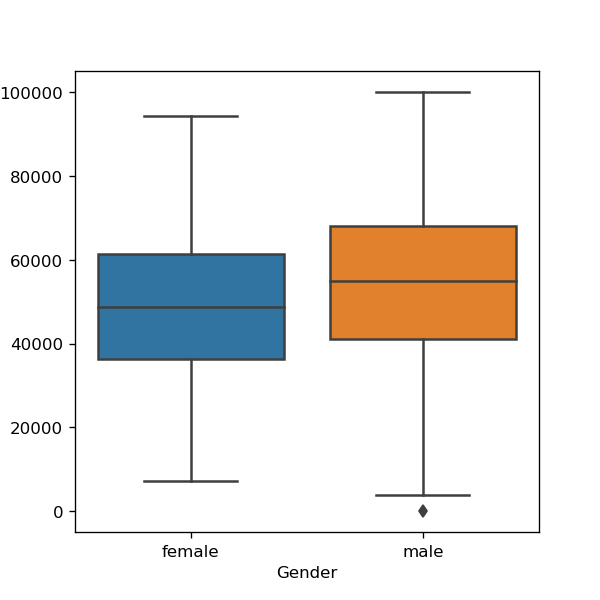

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='Gender', y='Salary', data = dataset)
plt.show()

<IPython.core.display.Javascript object>


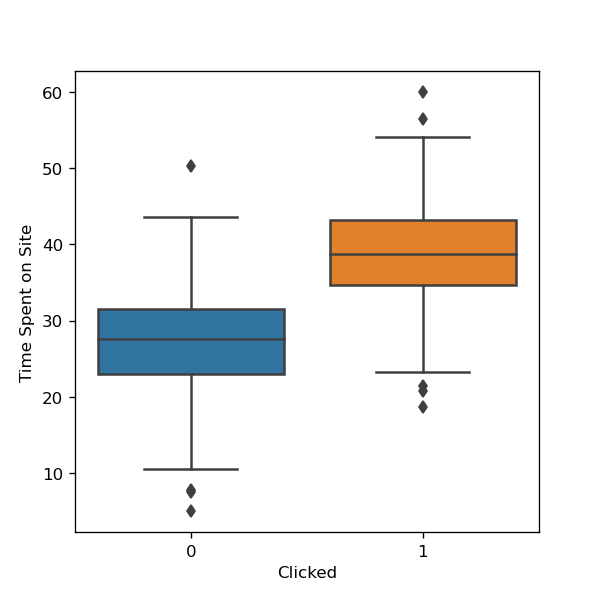

In [ ]:
plt.figure(figsize = (5,5))
sns.boxplot(x='Clicked', y = "Time Spent on Site", data = dataset)
plt.show()

<IPython.core.display.Javascript object>


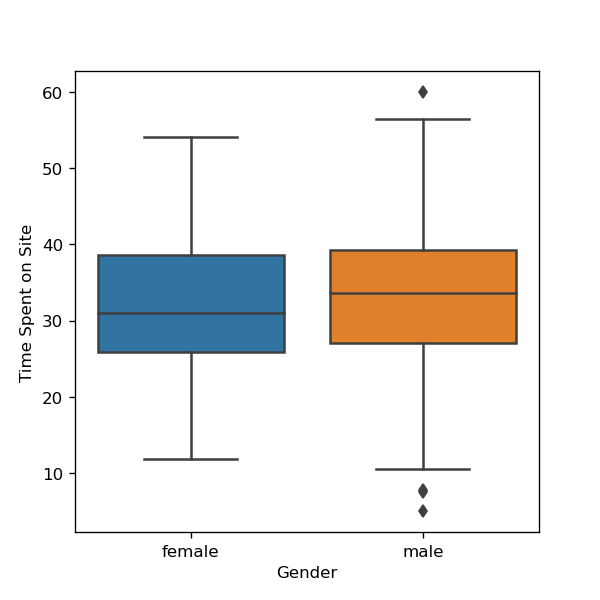

In [ ]:
plt.figure(figsize = (5,5))
sns.boxplot(x='Gender', y = "Time Spent on Site", data = dataset)
plt.show()

<IPython.core.display.Javascript object>


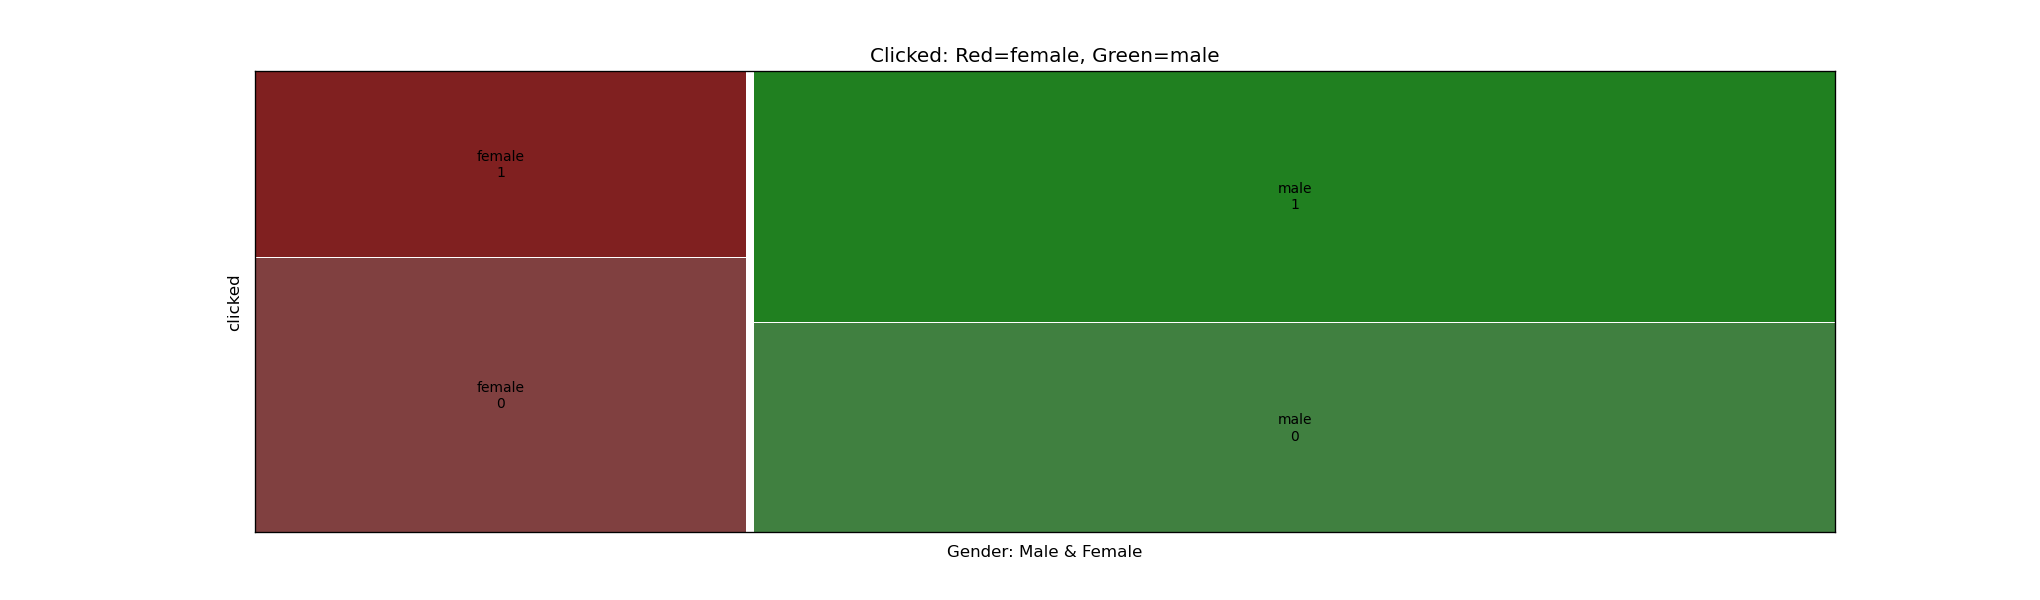

In [ ]:
# Mosaic Chart
plt.rc('figure', figsize=(17, 5))
mosaic(dataset,['Gender', 'Clicked'], axes_label=False, title='Clicked: Red=female, Green=male')
plt.xlabel('Gender: Male & Female')
plt.ylabel('clicked')
plt.show()

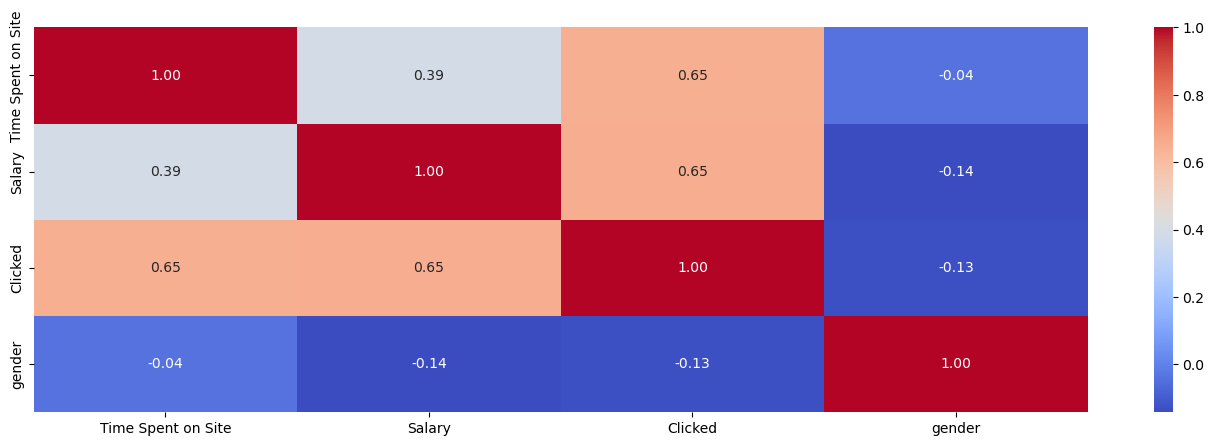

In [ ]:
g=sns.heatmap(dataset[["Time Spent on Site","Salary","Clicked", 'gender', 'Country', 'Country_Orig']].corr(),annot=True ,fmt=".2f", cmap="coolwarm")

## Transformations for Gender and Country

In [ ]:
#add columns to transform:
dataset['gender'] = dataset['Gender']

In [ ]:
#transform new columns:
enc = OrdinalEncoder()
dataset[['Country', 'Country_Orig', 'gender']] = enc.fit_transform(dataset[['Country', 'Country_Orig', 'gender']])

In [ ]:
dataset.corr()

,Country,Time Spent on Site,Salary,Clicked,Country_Orig,gender
Country,1.000000,0.078882,-0.023178,0.052661,0.823893,-0.022802
Time Spent on Site,0.078882,1.000000,0.388330,0.650781,0.053663,0.043625
Salary,-0.023178,0.388330,1.000000,0.654654,-0.001981,0.142045
Clicked,0.052661,0.650781,0.654654,1.000000,0.059615,0.131043
Country_Orig,0.823893,0.053663,-0.001981,0.059615,1.000000,0.009986
gender,-0.022802,0.043625,0.142045,0.131043,0.009986,1.000000


In [ ]:
dataset = dataset.drop(['Names', 'emails','Gender', 'Country', 'Country_Orig'], axis=1)

In [ ]:
checkDataForNulls(dataset)

                                Column  percent_missing
Time Spent on Site  Time Spent on Site              0.0
Salary                          Salary              0.0
Clicked                        Clicked              0.0
gender                          gender              0.0


### Modified dataset analysis
#### results with added variable

basic
Train: 
accuracy 0.9273182957393483


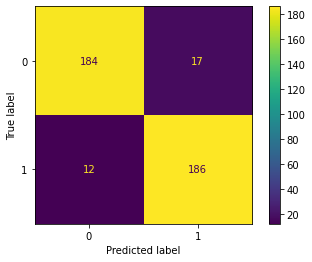

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       201
           1       0.92      0.94      0.93       198

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399

----------------------------------------------

Test: 
accuracy 0.87


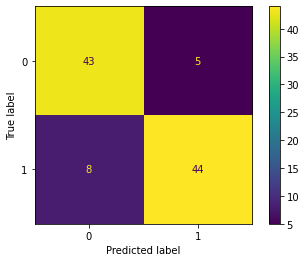

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
basic = train_report_hist('basic',StandardScaler(), LogisticRegression(random_state = 0), False, None)

#### results without added variable

basic_withoutGender
Train: 
accuracy 0.924812030075188


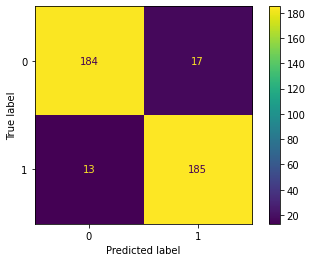

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.93       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.86


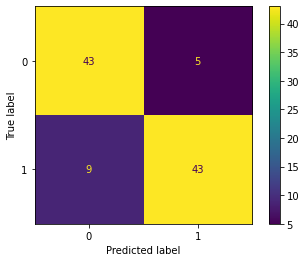

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        48
           1       0.90      0.83      0.86        52

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary'])
basic_withoutGender = train_report_hist('basic_withoutGender',StandardScaler(), LogisticRegression(random_state = 0), False, None)

In [ ]:
show_results()

Accuracy
             modelName  accuracy_test  accuracy_train
0                basic           0.87        0.927318
1  basic_withoutGender           0.86        0.924812
----------------------------------------------

RocAuc
             modelName  rocauc_test  rocauc_train
0                basic     0.870994      0.927408
1  basic_withoutGender     0.861378      0.924883
----------------------------------------------

Precision
             modelName  precision_test  precision_train
0                basic        0.897959         0.916256
1  basic_withoutGender        0.895833         0.915842
----------------------------------------------

Recall
             modelName  recall_test  recall_train
0                basic     0.846154      0.939394
1  basic_withoutGender     0.826923      0.934343
----------------------------------------------

f1
             modelName   f1_test  f1_train
0                basic  0.871287  0.927681
1  basic_withoutGender  0.860000  0.925000


results with added column gender show slightly better results. we`ll proceed with added column further

### Treat outliers
#### Overview
>#### Detecting outliers using the Inter Quantile Range

In [ ]:
sample_outliers_Salary = detect_outliers_iqr(dataset, 'Salary')
print("Outliers from IQR method: ", sample_outliers_Salary)

Outliers from IQR method:  []


In [ ]:
sample_outliers_Time_Spent_on_Site = detect_outliers_iqr(dataset, 'Time Spent on Site')
print("Outliers from IQR method: ", sample_outliers_Time_Spent_on_Site)

Outliers from IQR method:  [5.0, 60.0]


#### Median

In [ ]:
median = np.median(dataset['Time Spent on Site'])# Replace with median
s_array = dataset['Time Spent on Site'].to_numpy()
c = np.where(s_array==5, median, s_array)
d = np.where(s_array==60, median,c)
dataset['Time Spent on Site_Median']=pd.Series(d)

In [ ]:
median = np.median(dataset['Salary'])# Replace with median
s_array = dataset['Salary'].to_numpy()
c = np.where(s_array==20, median, s_array)
dataset['Salary_Median']=pd.Series(c)

In [ ]:
dataset.describe()

,Country,Time Spent on Site,Salary,Clicked,Country_Orig,gender,Time Spent on Site_Median,Salary_Median
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,83.134269,32.920178,52896.992469,0.501002,102.462926,0.687375,32.922968,53002.846002
std,51.373934,9.103455,18989.183150,0.500501,60.249749,0.464028,8.935062,18840.473594
min,0.000000,5.000000,20.000000,0.000000,0.000000,0.000000,7.521480,3993.153747
25%,42.000000,26.425044,38888.117260,0.000000,52.000000,0.000000,26.489509,39010.177645
50%,78.000000,33.196067,52840.913110,1.000000,100.000000,1.000000,33.196067,52840.913110
75%,128.000000,39.114995,65837.288190,1.000000,155.500000,1.000000,39.052547,65837.288190
max,169.000000,60.000000,100000.000000,1.000000,209.000000,1.000000,56.434684,100000.000000


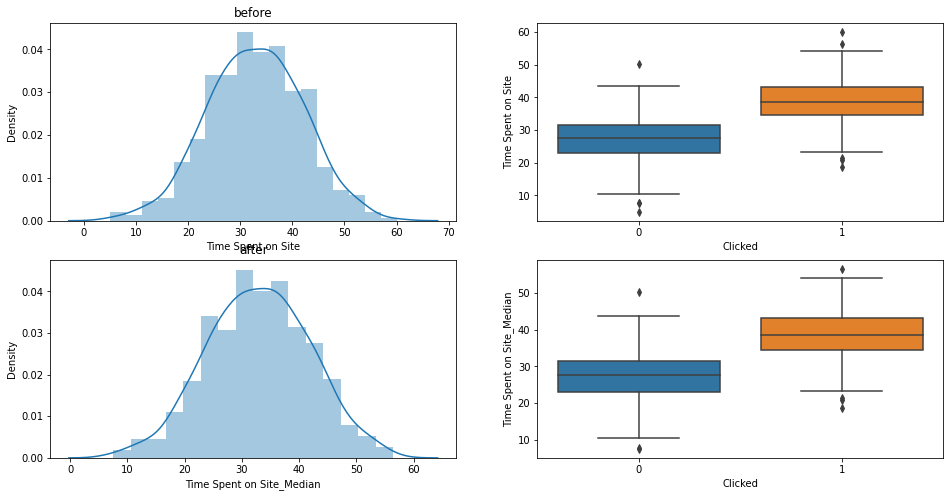

In [ ]:
norm_bp_compare('Time Spent on Site', 'Time Spent on Site_Median')

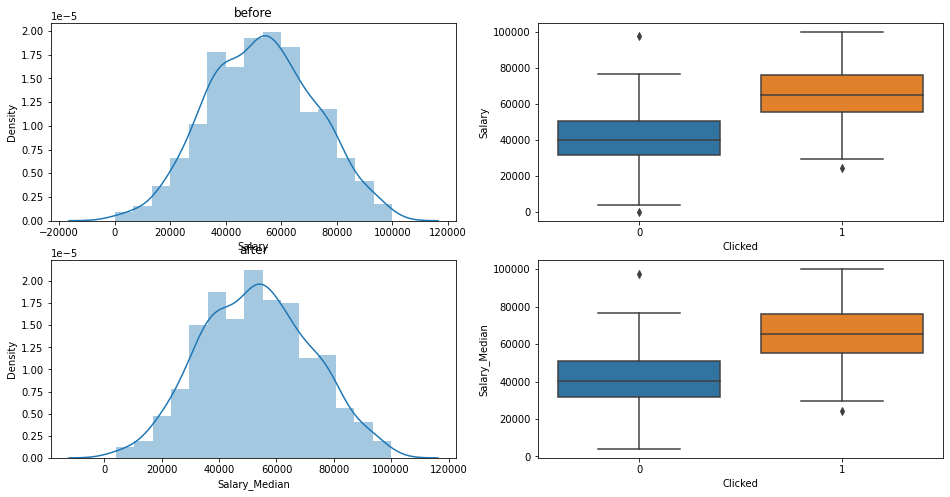

In [ ]:
norm_bp_compare('Salary', 'Salary_Median')

basic_Time_Spent_on_Site_Median
Train: 
accuracy 0.9273182957393483


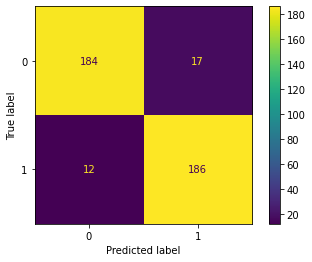

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       201
           1       0.92      0.94      0.93       198

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399

----------------------------------------------

Test: 
accuracy 0.87


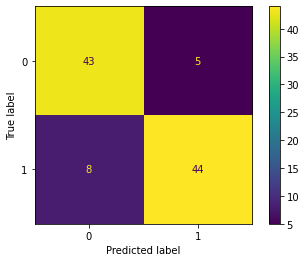

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Median', 'Salary', 'gender'])
basic_Time_Spent_on_Site_Median = train_report_hist('basic_Time_Spent_on_Site_Median',StandardScaler(), LogisticRegression(random_state = 0), False, None)

basic_Salary_Median
Train: 
accuracy 0.9273182957393483


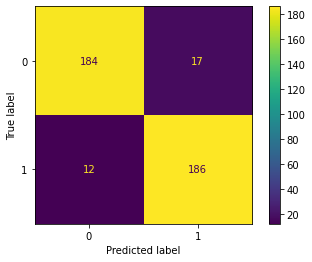

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       201
           1       0.92      0.94      0.93       198

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399

----------------------------------------------

Test: 
accuracy 0.87


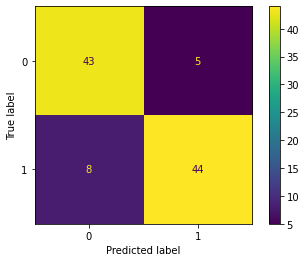

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary_Median', 'gender'])
basic_Salary_Median = train_report_hist('basic_Salary_Median',StandardScaler(), LogisticRegression(random_state = 0), False, None)

basic_Both_Median
Train: 
accuracy 0.924812030075188


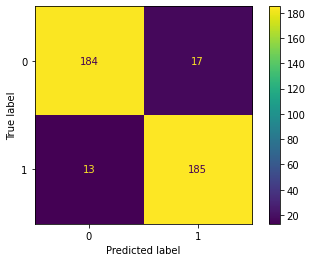

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.93       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


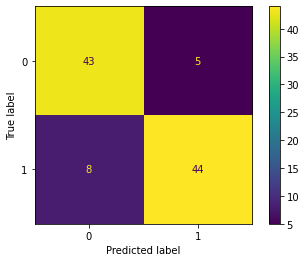

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Median', 'Salary_Median', 'gender'])
basic_Both_Median = train_report_hist('basic_Both_Median',StandardScaler(), LogisticRegression(random_state = 0), False, None)

#### Trimming

18.757544777 44.45195104


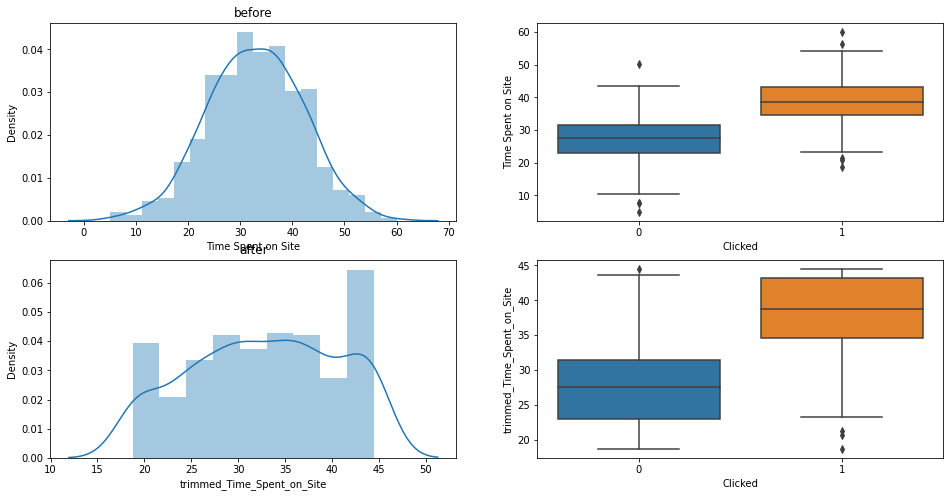

In [ ]:
trimming('Time Spent on Site', 'trimmed_Time_Spent_on_Site')

basic_trimmed_Time_Spent_on_Site
Train: 
accuracy 0.9273182957393483


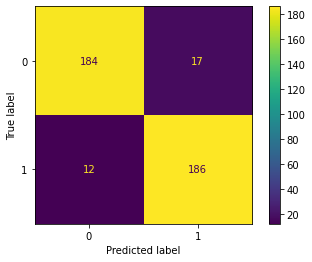

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       201
           1       0.92      0.94      0.93       198

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399

----------------------------------------------

Test: 
accuracy 0.87


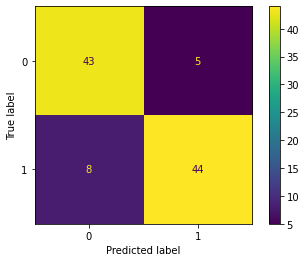

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
#check model where only variable time spent on site was capped and trimmed
X_train, X_test, y_train, y_test = reset_t_t_split(['trimmed_Time_Spent_on_Site', 'Salary', 'gender'])
basic_trimmed_Time_Spent_on_Site = train_report_hist('basic_trimmed_Time_Spent_on_Site',StandardScaler(), LogisticRegression(random_state = 0), False, None)

22815.76983 77881.194518


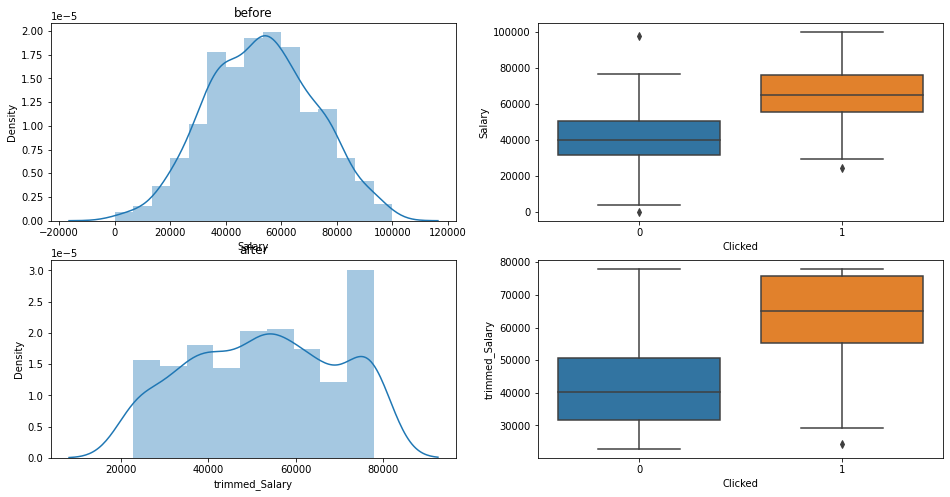

In [ ]:
trimming('Salary', 'trimmed_Salary')

basic_trimmed_Salary
Train: 
accuracy 0.924812030075188


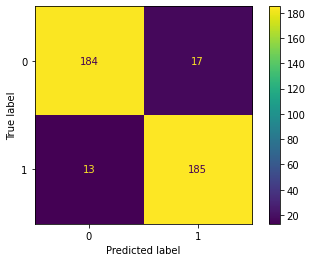

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.93       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


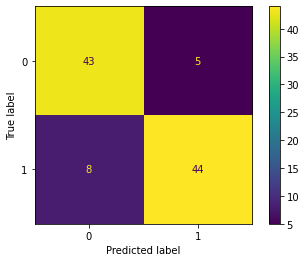

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
#check model where only variable salary was capped and trimmed
X_train, X_test, y_train, y_test = reset_t_t_split(['trimmed_Salary', 'Time Spent on Site', 'gender'])
basic_trimmed_Salary = train_report_hist('basic_trimmed_Salary',StandardScaler(), LogisticRegression(random_state = 0), False, None)

In [ ]:
show_results()

Accuracy
                          modelName  accuracy_test  accuracy_train
0                             basic           0.87        0.927318
2   basic_Time_Spent_on_Site_Median           0.87        0.927318
3               basic_Salary_Median           0.87        0.927318
4                 basic_Both_Median           0.87        0.924812
5  basic_trimmed_Time_Spent_on_Site           0.87        0.927318
6              basic_trimmed_Salary           0.87        0.924812
1               basic_withoutGender           0.86        0.924812
----------------------------------------------

RocAuc
                          modelName  rocauc_test  rocauc_train
0                             basic     0.870994      0.927408
2   basic_Time_Spent_on_Site_Median     0.870994      0.927408
3               basic_Salary_Median     0.870994      0.927408
4                 basic_Both_Median     0.870994      0.924883
5  basic_trimmed_Time_Spent_on_Site     0.870994      0.927408
6              basic_t

as results show after preprocessing there were no improvements, so we`ll go with original dataset

### Discretization

In [ ]:
dataset['Salary_Discr'] = dataset['Salary']
dataset['Time Spent on Site_Discr'] = dataset['Time Spent on Site']

X_train_d, X_test_d, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr', 'gender'])
X_train, X_test = discr()

basic_Discr
Train: 
accuracy 0.9172932330827067


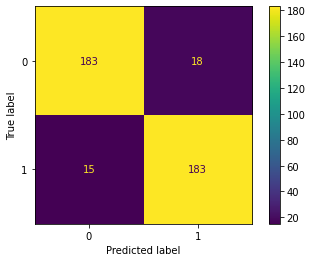

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       201
           1       0.91      0.92      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.88


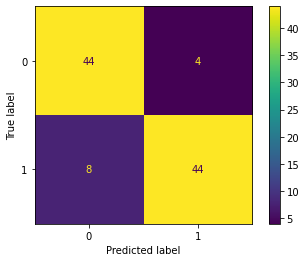

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        48
           1       0.92      0.85      0.88        52

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100



In [ ]:
#check results with variables time spent on site and salary discritized
basic_Discr = train_report_hist('basic_Discr',StandardScaler(), LogisticRegression(random_state = 0), False, None)

In [ ]:
show_results()

Accuracy
                          modelName  accuracy_test  accuracy_train
7                       basic_Discr           0.88        0.917293
0                             basic           0.87        0.927318
2   basic_Time_Spent_on_Site_Median           0.87        0.927318
3               basic_Salary_Median           0.87        0.927318
4                 basic_Both_Median           0.87        0.924812
5  basic_trimmed_Time_Spent_on_Site           0.87        0.927318
6              basic_trimmed_Salary           0.87        0.924812
1               basic_withoutGender           0.86        0.924812
----------------------------------------------

RocAuc
                          modelName  rocauc_test  rocauc_train
7                       basic_Discr     0.881410      0.917345
0                             basic     0.870994      0.927408
2   basic_Time_Spent_on_Site_Median     0.870994      0.927408
3               basic_Salary_Median     0.870994      0.927408
4                 

as we see dicritization slightly improved results and well use it in further model training

### Normalisation

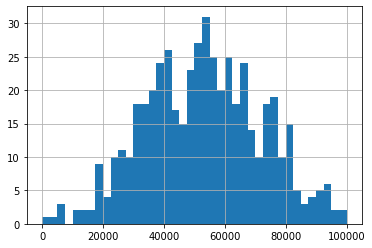

In [ ]:
%matplotlib inline
dataset['Salary'].hist(bins = 40)
plt.show()

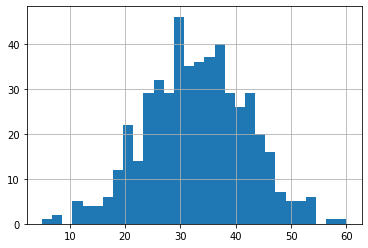

In [ ]:
dataset['Time Spent on Site'].hist(bins=30)
plt.show()

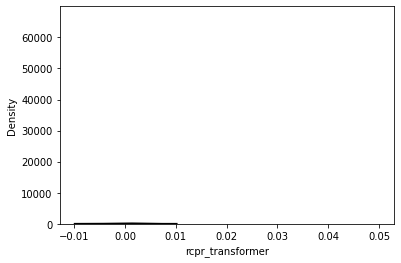

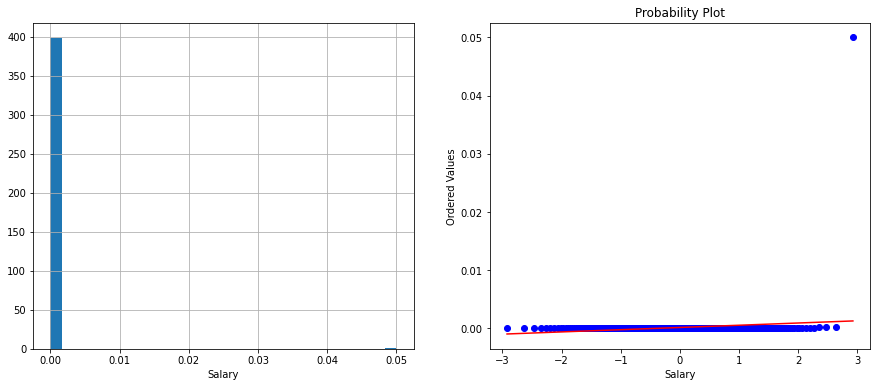

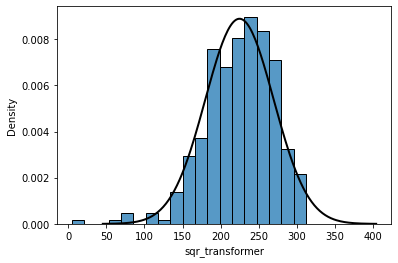

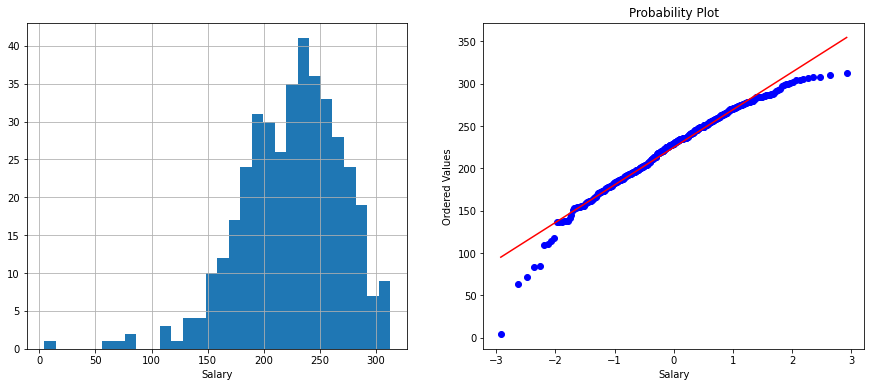

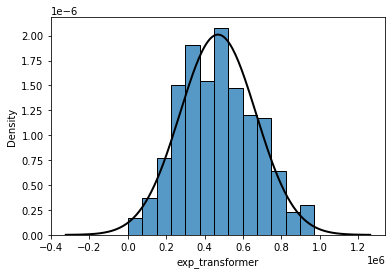

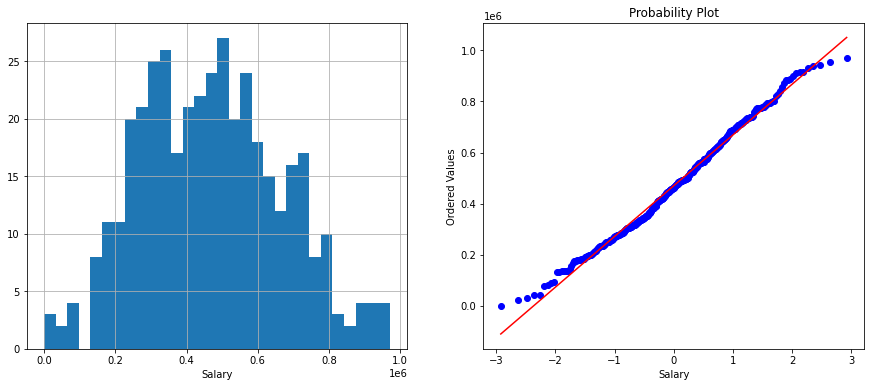

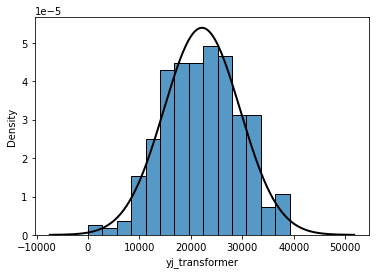

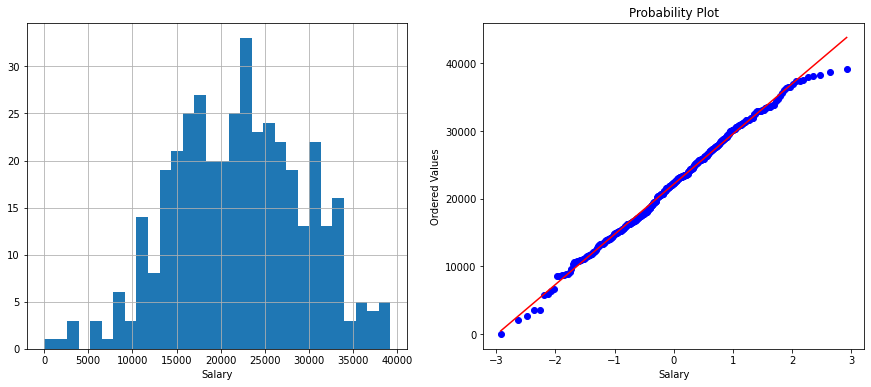

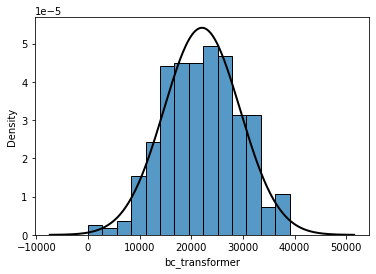

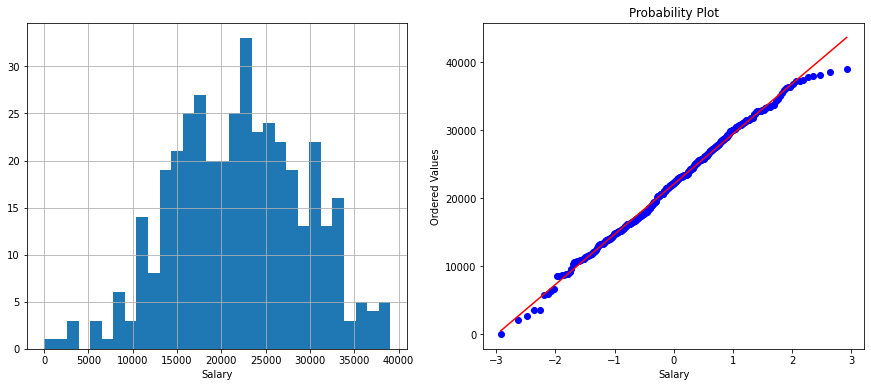

In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
transform(X_train,['Time Spent on Site', 'Salary'], 'Salary')

rcpr transformer showed bad results and except rcpr we`ll use other 4 transfromers to check results

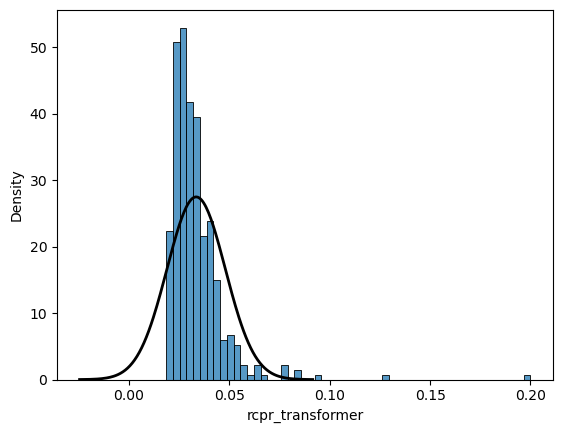

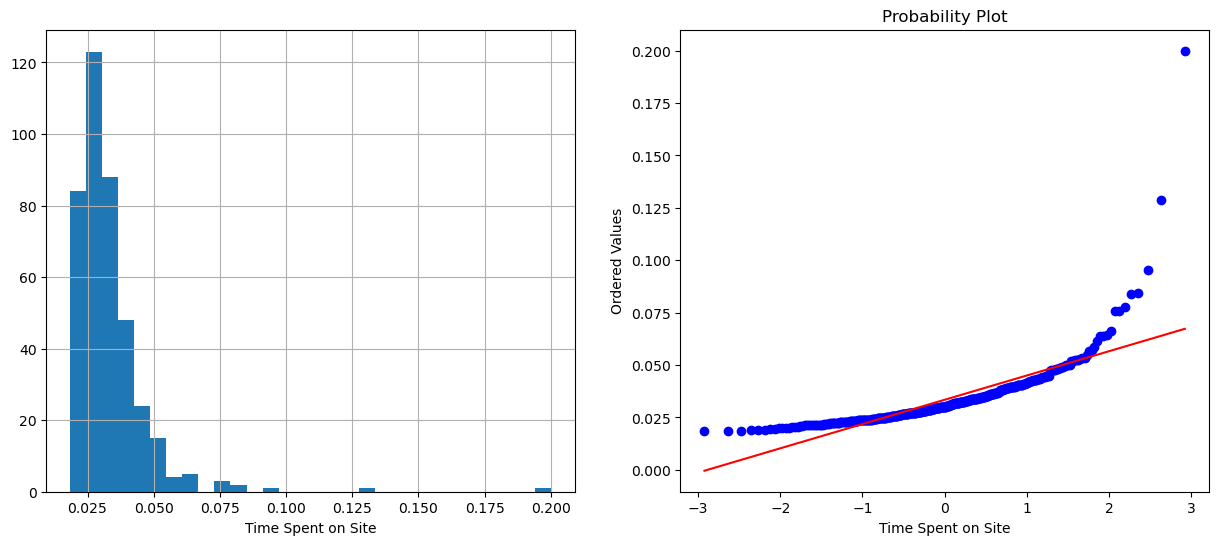

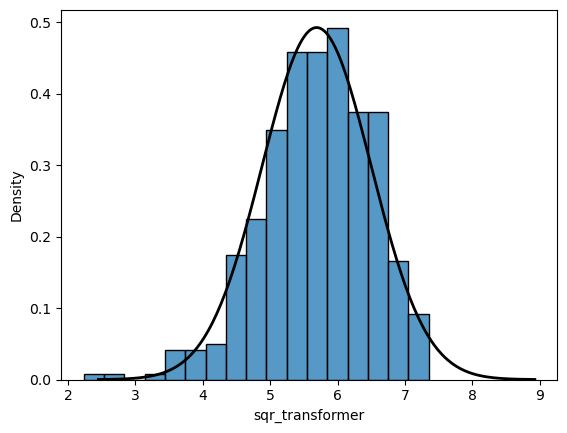

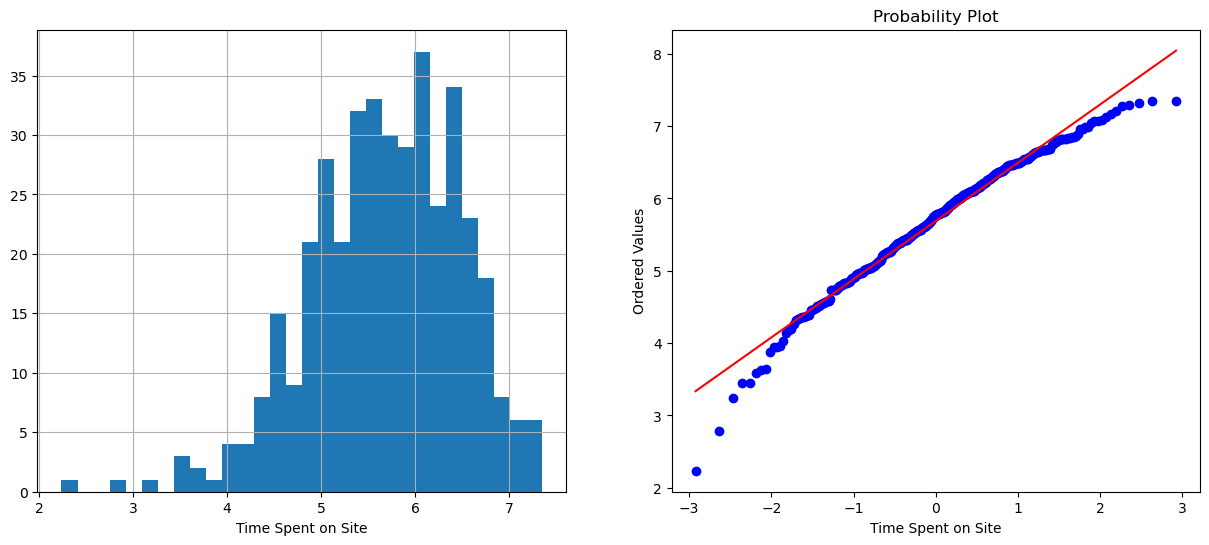

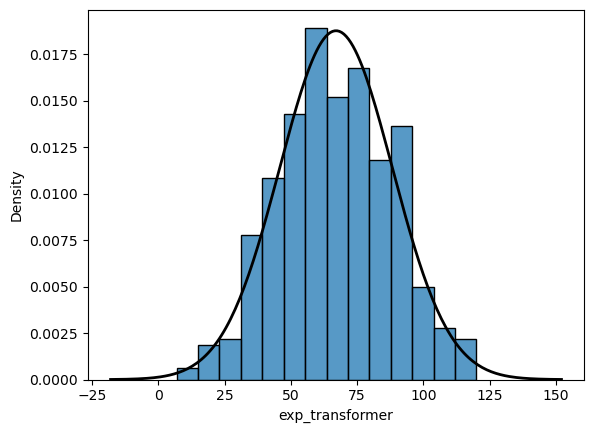

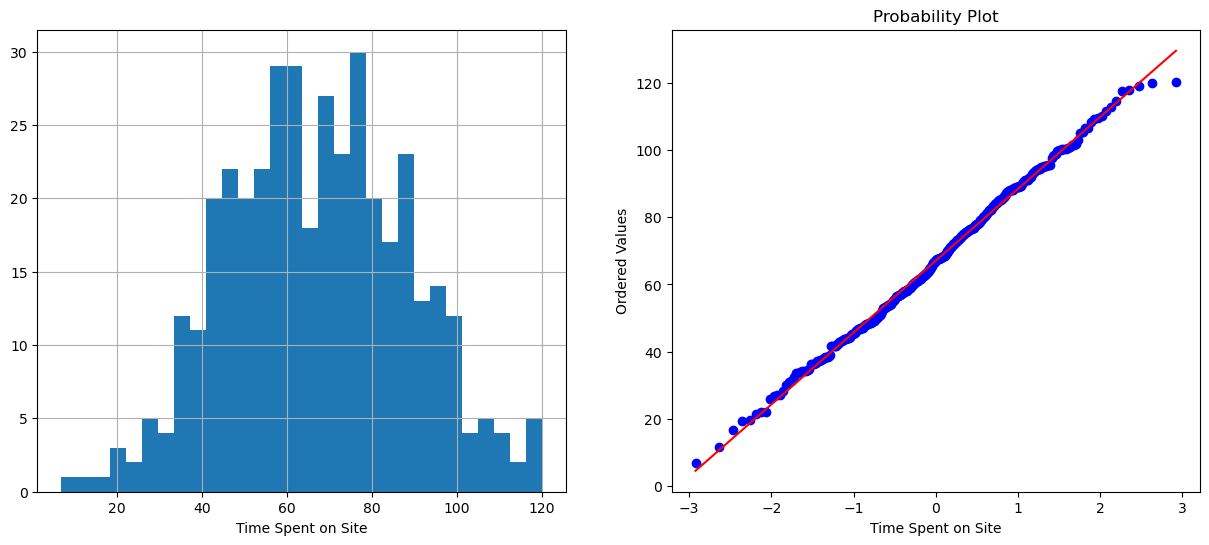

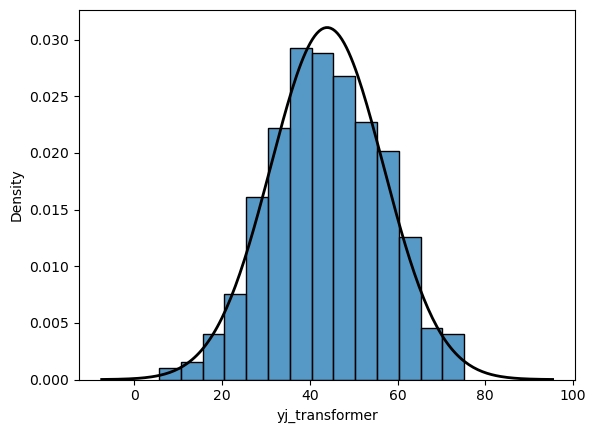

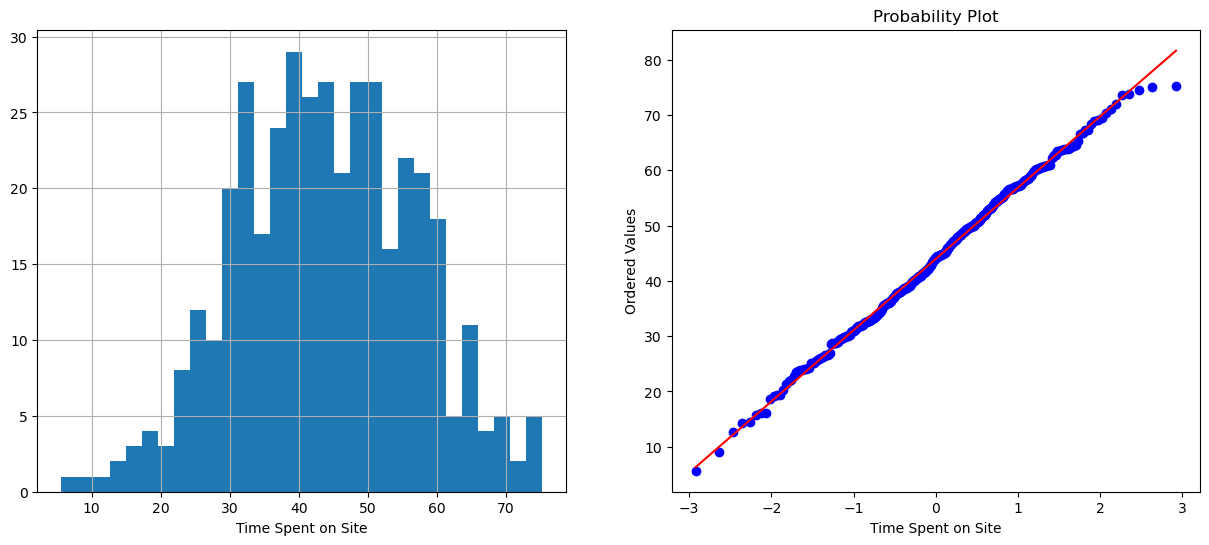

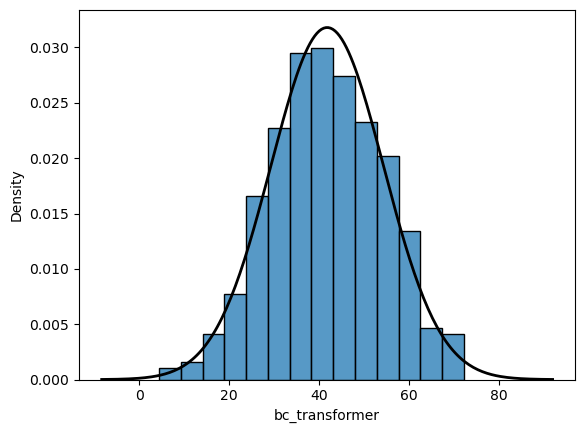

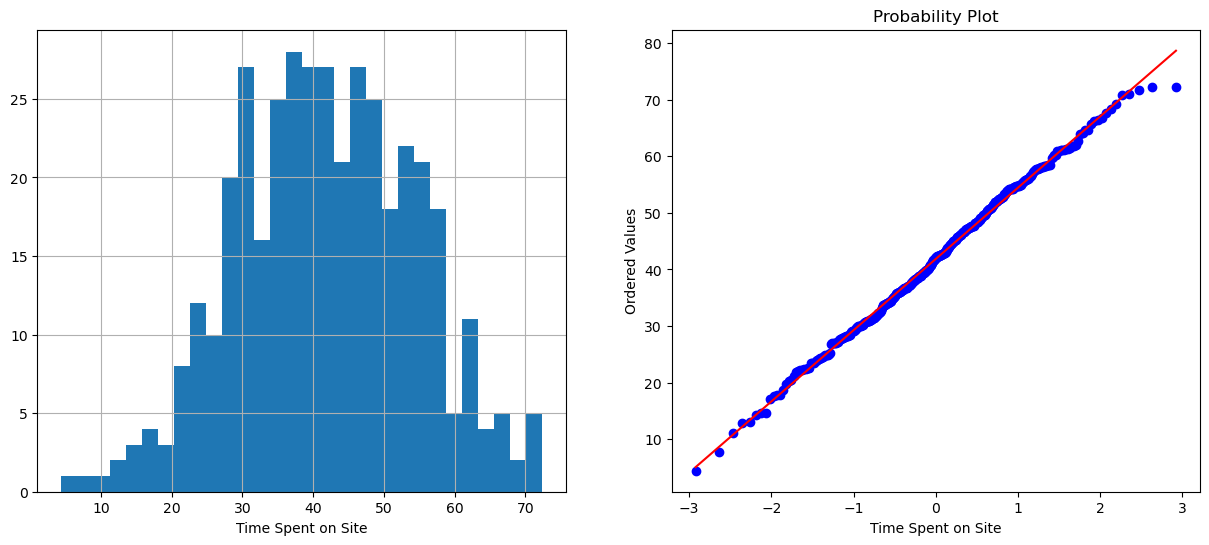

In [ ]:
transform(X_train,['Time Spent on Site', 'Salary'], 'Time Spent on Site')

as we see results of rcpr transfromer are far from normal distribution and we`ll use all other 4 transfromers only to check results

basic_yjTransformer
Train: 
accuracy 0.9273182957393483


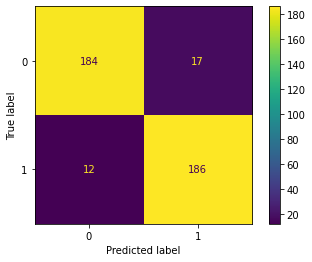

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       201
           1       0.92      0.94      0.93       198

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399

----------------------------------------------

Test: 
accuracy 0.87


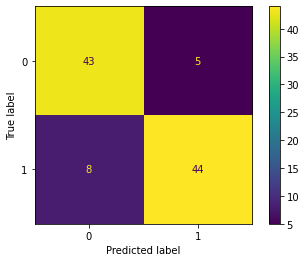

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
basic_yjTransformer = train_report_hist('basic_yjTransformer',StandardScaler(), LogisticRegression(random_state = 0), True, PowerTransformer(method = 'yeo-johnson', standardize = False))

basic_bcTransformer
Train: 
accuracy 0.924812030075188


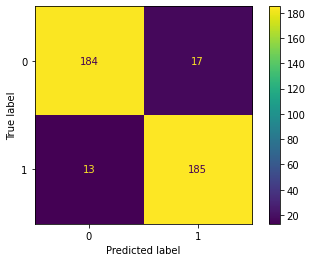

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.93       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.86


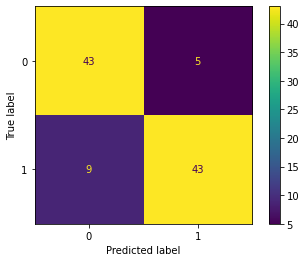

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        48
           1       0.90      0.83      0.86        52

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary'])
basic_bcTransformer= train_report_hist('basic_bcTransformer',StandardScaler(), LogisticRegression(random_state = 0), True, PowerTransformer(method = 'box-cox', standardize = False))

basic_expTransformer
Train: 
accuracy 0.924812030075188


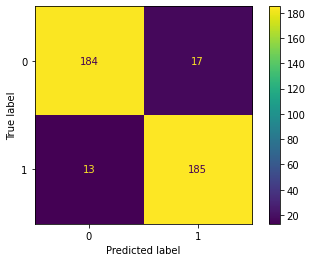

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.93       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.86


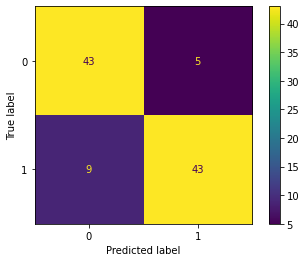

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        48
           1       0.90      0.83      0.86        52

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
basic_expTransformer= train_report_hist('basic_expTransformer',StandardScaler(), LogisticRegression(random_state = 0), True, FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True))

basic_sqrTransformer
Train: 
accuracy 0.9197994987468672


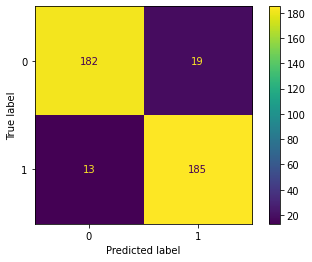

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       201
           1       0.91      0.93      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


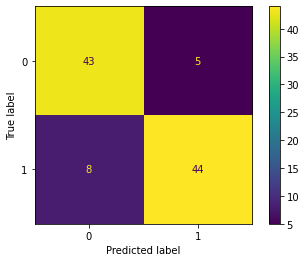

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
basic_sqrTransformer = train_report_hist('basic_sqrTransformer',StandardScaler(), LogisticRegression(random_state = 0), True, FunctionTransformer(lambda x: x ** (1 / 2), validate = True))

In [ ]:
show_results()

Accuracy
                           modelName  accuracy_test  accuracy_train
7                        basic_Discr           0.88        0.917293
0                              basic           0.87        0.927318
2    basic_Time_Spent_on_Site_Median           0.87        0.927318
3                basic_Salary_Median           0.87        0.927318
4                  basic_Both_Median           0.87        0.924812
5   basic_trimmed_Time_Spent_on_Site           0.87        0.927318
6               basic_trimmed_Salary           0.87        0.924812
8                basic_yjTransformer           0.87        0.927318
11              basic_sqrTransformer           0.87        0.919799
1                basic_withoutGender           0.86        0.924812
9                basic_bcTransformer           0.86        0.924812
10              basic_expTransformer           0.86        0.924812
----------------------------------------------

RocAuc
                           modelName  rocauc_test  r

### Scalers
#### MinMaxScaler

basic_mmScaler
Train: 
accuracy 0.924812030075188


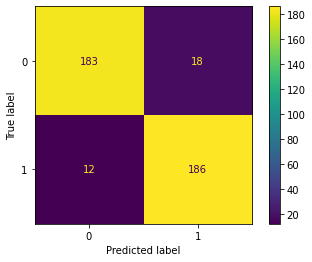

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       201
           1       0.91      0.94      0.93       198

    accuracy                           0.92       399
   macro avg       0.93      0.92      0.92       399
weighted avg       0.93      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


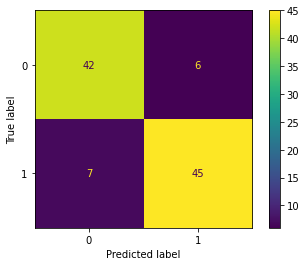

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        48
           1       0.88      0.87      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
basic_mmScaler = train_report_hist('basic_mmScaler',MinMaxScaler(), LogisticRegression(random_state = 0), False, None)

#### MaxAbsScaler

basic_masScaler
Train: 
accuracy 0.924812030075188


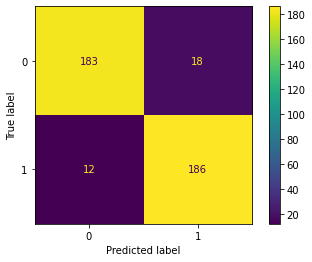

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       201
           1       0.91      0.94      0.93       198

    accuracy                           0.92       399
   macro avg       0.93      0.92      0.92       399
weighted avg       0.93      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


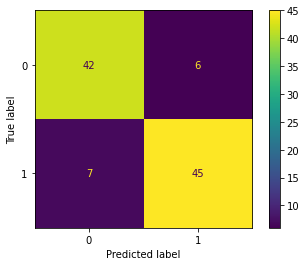

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        48
           1       0.88      0.87      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
basic_masScaler = train_report_hist('basic_masScaler',MaxAbsScaler(), LogisticRegression(random_state = 0), False, None)

#### Robust Scaler

basic_rsScaler
Train: 
accuracy 0.924812030075188


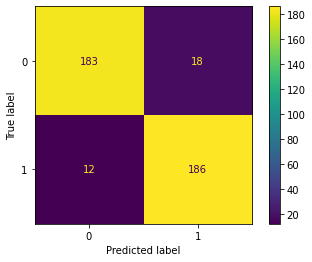

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       201
           1       0.91      0.94      0.93       198

    accuracy                           0.92       399
   macro avg       0.93      0.92      0.92       399
weighted avg       0.93      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


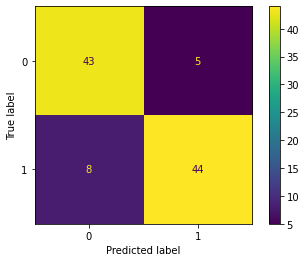

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
basic_rsScaler = train_report_hist('basic_rsScaler',RobustScaler(), LogisticRegression(random_state = 0), False, None)

In [ ]:
show_results()

Accuracy
                           modelName  accuracy_test  accuracy_train
7                        basic_Discr           0.88        0.917293
0                              basic           0.87        0.927318
2    basic_Time_Spent_on_Site_Median           0.87        0.927318
3                basic_Salary_Median           0.87        0.927318
4                  basic_Both_Median           0.87        0.924812
5   basic_trimmed_Time_Spent_on_Site           0.87        0.927318
6               basic_trimmed_Salary           0.87        0.924812
8                basic_yjTransformer           0.87        0.927318
11              basic_sqrTransformer           0.87        0.919799
12                    basic_mmScaler           0.87        0.924812
13                   basic_masScaler           0.87        0.924812
14                    basic_rsScaler           0.87        0.924812
1                basic_withoutGender           0.86        0.924812
9                basic_bcTransformer   

results with use of other scalers gave no improvement.

### Classifiers

KNeighbors
Train: 
accuracy 0.9298245614035088


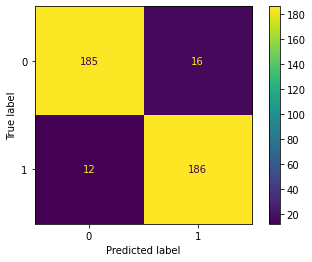

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       201
           1       0.92      0.94      0.93       198

    accuracy                           0.93       399
   macro avg       0.93      0.93      0.93       399
weighted avg       0.93      0.93      0.93       399

----------------------------------------------

Test: 
accuracy 0.84


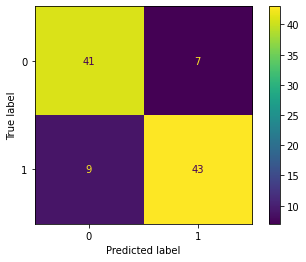

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        48
           1       0.86      0.83      0.84        52

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
KNeighbors = train_report_hist('KNeighbors',StandardScaler(),  KNeighborsClassifier(), False, None)

SupportVectorC
Train: 
accuracy 0.9197994987468672


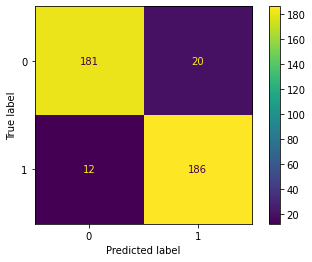

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       201
           1       0.90      0.94      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.86


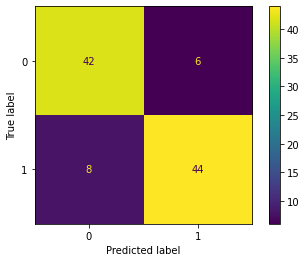

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        48
           1       0.88      0.85      0.86        52

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
SupportVectorC = train_report_hist('SupportVectorC',StandardScaler(),   SVC(kernel="linear", C=0.025), False, None)

SupportVectorC_Discr_noGender
Train: 
accuracy 0.9172932330827067


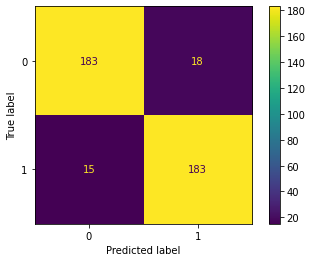

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       201
           1       0.91      0.92      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.89


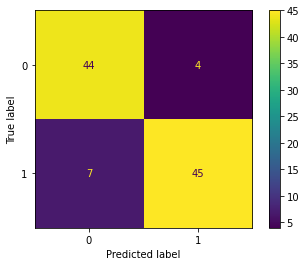

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        48
           1       0.92      0.87      0.89        52

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [ ]:
#dataset discretized
X_train_d, X_test_d, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr'])
X_train, X_test = discr()
SupportVectorC_Discr_noGender = train_report_hist('SupportVectorC_Discr_noGender',StandardScaler(),   SVC(kernel="linear", C=0.025), False, None)

GaussianProcessC
Train: 
accuracy 0.9223057644110275


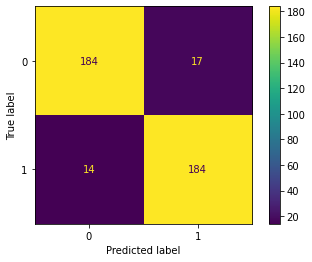

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


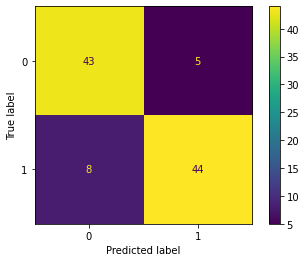

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.90      0.85      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
GaussianProcessC = train_report_hist('GaussianProcessC',StandardScaler(),   GaussianProcessClassifier(1.0 * RBF(1.0)), False, None)

GaussianProcessC__Discr
Train: 
accuracy 0.9223057644110275


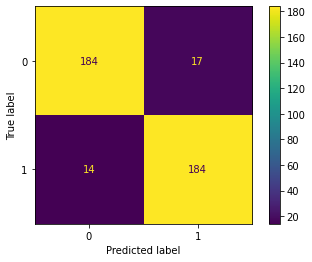

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.87


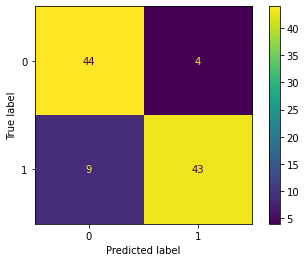

              precision    recall  f1-score   support

           0       0.83      0.92      0.87        48
           1       0.91      0.83      0.87        52

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [ ]:
X_train_d, X_test_d, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr', 'gender'])
X_train, X_test = discr()
GaussianProcessC__Discr = train_report_hist('GaussianProcessC__Discr',StandardScaler(),   GaussianProcessClassifier(1.0 * RBF(1.0)), False, None)

DecisionTreeC
Train: 
accuracy 0.9674185463659147


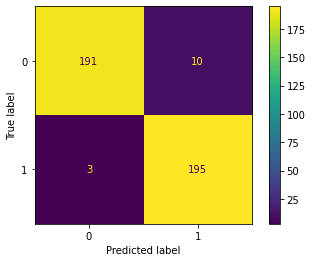

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       201
           1       0.95      0.98      0.97       198

    accuracy                           0.97       399
   macro avg       0.97      0.97      0.97       399
weighted avg       0.97      0.97      0.97       399

----------------------------------------------

Test: 
accuracy 0.79


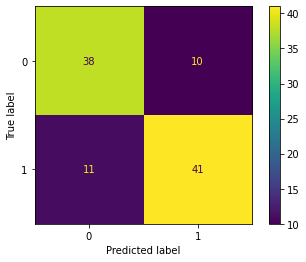

              precision    recall  f1-score   support

           0       0.78      0.79      0.78        48
           1       0.80      0.79      0.80        52

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
DecisionTreeC = train_report_hist('DecisionTreeC',StandardScaler(),  DecisionTreeClassifier(max_depth=5), False, None)

RandomForestC_noTransformer
Train: 
accuracy 0.9473684210526315


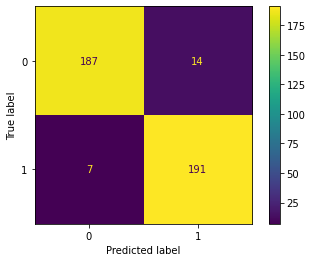

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       201
           1       0.93      0.96      0.95       198

    accuracy                           0.95       399
   macro avg       0.95      0.95      0.95       399
weighted avg       0.95      0.95      0.95       399

----------------------------------------------

Test: 
accuracy 0.82


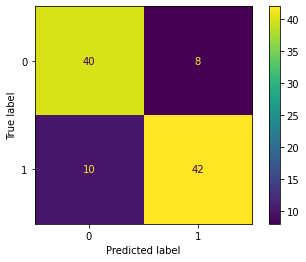

              precision    recall  f1-score   support

           0       0.80      0.83      0.82        48
           1       0.84      0.81      0.82        52

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
RandomForestC_noTransformer= train_report_hist('RandomForestC_noTransformer',StandardScaler(),  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), False, None)

AdaBoostC
Train: 
accuracy 0.9624060150375939


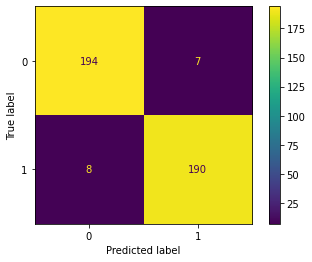

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       201
           1       0.96      0.96      0.96       198

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      0.96       399

----------------------------------------------

Test: 
accuracy 0.86


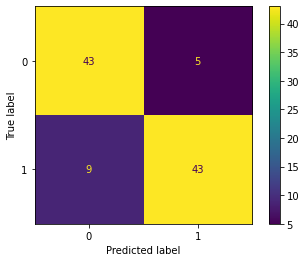

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        48
           1       0.90      0.83      0.86        52

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
AdaBoostC = train_report_hist('AdaBoostC',StandardScaler(), AdaBoostClassifier(), False, None)

AdaBoostC_Discr
Train: 
accuracy 0.9172932330827067


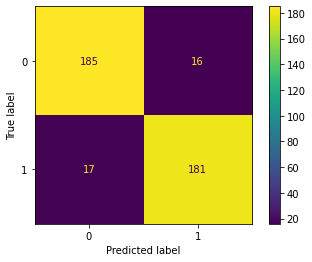

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       201
           1       0.92      0.91      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.85


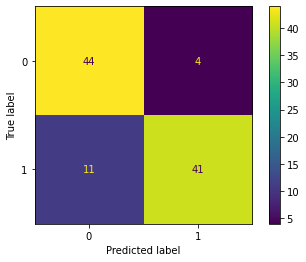

              precision    recall  f1-score   support

           0       0.80      0.92      0.85        48
           1       0.91      0.79      0.85        52

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



In [ ]:
X_train_d, X_test_d, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr'])
X_train, X_test = discr()
AdaBoostC_Discr = train_report_hist('AdaBoostC_Discr',StandardScaler(), AdaBoostClassifier(), False, None)

GaussianNB
Train: 
accuracy 0.924812030075188


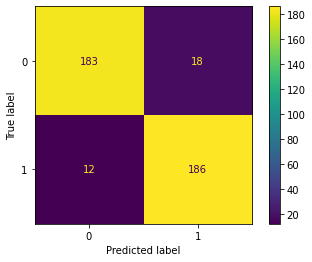

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       201
           1       0.91      0.94      0.93       198

    accuracy                           0.92       399
   macro avg       0.93      0.92      0.92       399
weighted avg       0.93      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.86


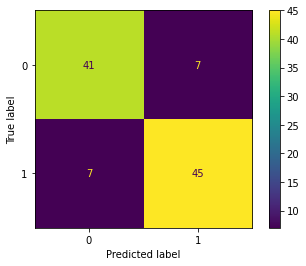

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        48
           1       0.87      0.87      0.87        52

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site', 'Salary', 'gender'])
GaussianNB = train_report_hist('GaussianNB',StandardScaler(), GaussianNB(), False, None)

In [ ]:
show_results()

Accuracy
                           modelName  accuracy_test  accuracy_train
17     SupportVectorC_Discr_noGender           0.89        0.917293
7                        basic_Discr           0.88        0.917293
0                              basic           0.87        0.927318
11              basic_sqrTransformer           0.87        0.919799
19           GaussianProcessC__Discr           0.87        0.922306
18                  GaussianProcessC           0.87        0.922306
14                    basic_rsScaler           0.87        0.924812
13                   basic_masScaler           0.87        0.924812
12                    basic_mmScaler           0.87        0.924812
8                basic_yjTransformer           0.87        0.927318
6               basic_trimmed_Salary           0.87        0.924812
5   basic_trimmed_Time_Spent_on_Site           0.87        0.927318
4                  basic_Both_Median           0.87        0.924812
3                basic_Salary_Median   

three models with discretized data showed better results. we`ll use gridsearch and try to tune hyper parameters

### Find Hyper Parameters
#### 1st model (Support Vector Classifier + Discretization + noGender)
>#### EqualFrequencyDiscretiser

In [ ]:
param_grid={'discr__q': [13,12,14,15,11],
            'clf__C': [1.85, 1.86, 1.87, 1.89, 1.91, 2.92, 1.95, 1.97]
           }

In [ ]:
nb = Pipeline([('discr', EqualFrequencyDiscretiser(variables=['Time Spent on Site_Discr', 'Salary_Discr'])),
               ('stsc', StandardScaler()),
               ('clf', SVC(kernel="linear")),
              ])

In [ ]:
grid_search = GridSearchCV(nb, param_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')

In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr'])
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('discr',
                                        EqualFrequencyDiscretiser(variables=['Time '
                                                                             'Spent '
                                                                             'on '
                                                                             'Site_Discr',
                                                                             'Salary_Discr'])),
                                       ('stsc', StandardScaler()),
                                       ('clf', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [1.85, 1.86, 1.87, 1.89, 1.91, 2.92, 1.95,
                                    1.97],
                         'discr__q': [13, 12, 14, 15, 11]},
             scoring='accuracy')

In [ ]:
grid_search.best_params_

{'clf__C': 1.86, 'discr__q': 13}

SVClassifier_Discr_Hyper
Train: 
accuracy 0.924812030075188


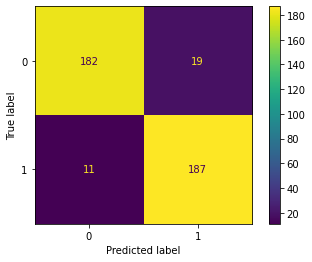

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       201
           1       0.91      0.94      0.93       198

    accuracy                           0.92       399
   macro avg       0.93      0.92      0.92       399
weighted avg       0.93      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.89


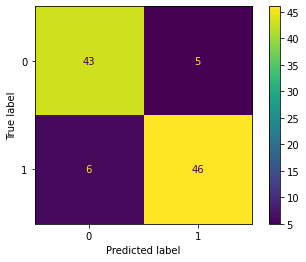

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        48
           1       0.90      0.88      0.89        52

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr'])
disc = EqualFrequencyDiscretiser(q=13, variables=['Time Spent on Site_Discr', 'Salary_Discr'])
disc.fit(X_train)
X_train= disc.transform(X_train)
X_test= disc.transform(X_test)
train_report_hist('SVClassifier_Discr_Hyper',StandardScaler(), SVC(kernel="linear", C = 1.89), False, None)

>#### KBinsDiscretizer

In [ ]:
param_grid={'discr__strategy': ['quantile', 'kmeans', 'quantile'],
            'discr__n_bins': [5, 10, 15, 3],
            'clf__C': [0.5, 1, 1.5, 2]
           }

In [ ]:
nb = Pipeline([('discr', KBinsDiscretizer(encode= 'ordinal')),
               ('stsc', StandardScaler()),
               ('clf', SVC(kernel="linear")),
              ])

In [ ]:
grid_search = GridSearchCV(nb, param_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')

In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr'])
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('discr',
                                        KBinsDiscretizer(encode='ordinal')),
                                       ('stsc', StandardScaler()),
                                       ('clf', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.5, 1, 1.5, 2],
                         'discr__n_bins': [5, 10, 15, 3],
                         'discr__strategy': ['quantile', 'kmeans', 'quantile']},
             scoring='accuracy')

In [ ]:
grid_search.best_params_

{'clf__C': 0.5, 'discr__n_bins': 15, 'discr__strategy': 'kmeans'}

In [ ]:
KBinsDiscretizer?

SVClassifier_KBinsDiscr_noGender_Hyper
Train: 
accuracy 0.899749373433584


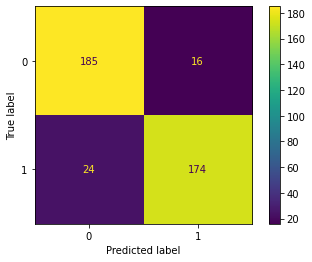

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       201
           1       0.92      0.88      0.90       198

    accuracy                           0.90       399
   macro avg       0.90      0.90      0.90       399
weighted avg       0.90      0.90      0.90       399

----------------------------------------------

Test: 
accuracy 0.89


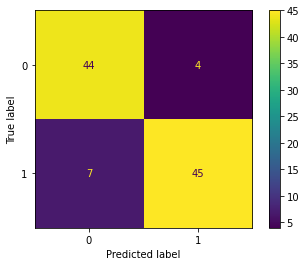

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        48
           1       0.92      0.87      0.89        52

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr'])
disc =  KBinsDiscretizer(encode= 'ordinal', n_bins = 5, strategy = 'kmeans')
disc.fit(X_train)
X_train= disc.transform(X_train)
X_test= disc.transform(X_test)
train_report_hist('SVClassifier_KBinsDiscr_noGender_Hyper',StandardScaler(), SVC(kernel="linear", C = 0.9), False, None)

#### 2nd model (LogisticRegression + Discretization + wGender)

In [ ]:
param_grid={'discr__q': [10, 12, 14, 16],
            'clf__C': [0.5, 0.7, 1, 1.5],
            'clf__penalty': ['l1', 'l2'],
            'clf__intercept_scaling': [0.5, 0.8, 1]
           }

In [ ]:
nb = Pipeline([('discr', EqualFrequencyDiscretiser(variables=['Time Spent on Site_Discr', 'Salary_Discr'])),
               ('stsc', StandardScaler()),
               ('clf', LogisticRegression(random_state = 0, solver='liblinear'))])

In [ ]:
grid_search = GridSearchCV(nb, param_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')

In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr'])
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('discr',
                                        EqualFrequencyDiscretiser(variables=['Time '
                                                                             'Spent '
                                                                             'on '
                                                                             'Site_Discr',
                                                                             'Salary_Discr'])),
                                       ('stsc', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.5, 0.7, 1, 1.5],
                         'clf__intercept_scaling': [0.5, 0.8, 1],
                         'clf__penalty': ['l1', 'l2'],
                         'discr__q': [10, 12, 14, 16]},
             scoring='accuracy')

In [ ]:
grid_search.best_params_

{'clf__C': 0.5,
 'clf__intercept_scaling': 0.5,
 'clf__penalty': 'l1',
 'discr__q': 16}

Basic_Hyper
Train: 
accuracy 0.9223057644110275


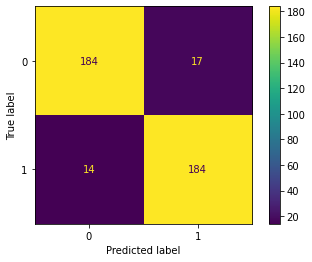

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       201
           1       0.92      0.93      0.92       198

    accuracy                           0.92       399
   macro avg       0.92      0.92      0.92       399
weighted avg       0.92      0.92      0.92       399

----------------------------------------------

Test: 
accuracy 0.89


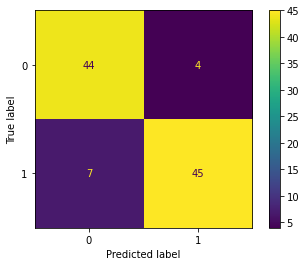

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        48
           1       0.92      0.87      0.89        52

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(['Time Spent on Site_Discr', 'Salary_Discr', 'gender'])
disc = EqualFrequencyDiscretiser(q=13, variables=['Time Spent on Site_Discr', 'Salary_Discr'])
disc.fit(X_train)
X_train= disc.transform(X_train)
X_test= disc.transform(X_test)
train_report_hist('Basic_Hyper',StandardScaler(), LogisticRegression(random_state = 0, solver='liblinear', C=0.25, penalty = 'l1', intercept_scaling = 0.3), False, None)

In [ ]:
show_results()

Accuracy
                                 modelName  accuracy_test  accuracy_train
27                             Basic_Hyper           0.89        0.922306
26  SVClassifier_KBinsDiscr_noGender_Hyper           0.89        0.899749
25                SVClassifier_Discr_Hyper           0.89        0.924812
17           SupportVectorC_Discr_noGender           0.89        0.917293
7                              basic_Discr           0.88        0.917293
11                    basic_sqrTransformer           0.87        0.919799
19                 GaussianProcessC__Discr           0.87        0.922306
18                        GaussianProcessC           0.87        0.922306
13                         basic_masScaler           0.87        0.924812
12                          basic_mmScaler           0.87        0.924812
0                                    basic           0.87        0.927318
4                        basic_Both_Median           0.87        0.924812
6                     basic_t

#Both models first and second after hyper parameters tuning showed best results. also no overfit can be seen, but both have in test results sencond type error 7 vs first type error 4.